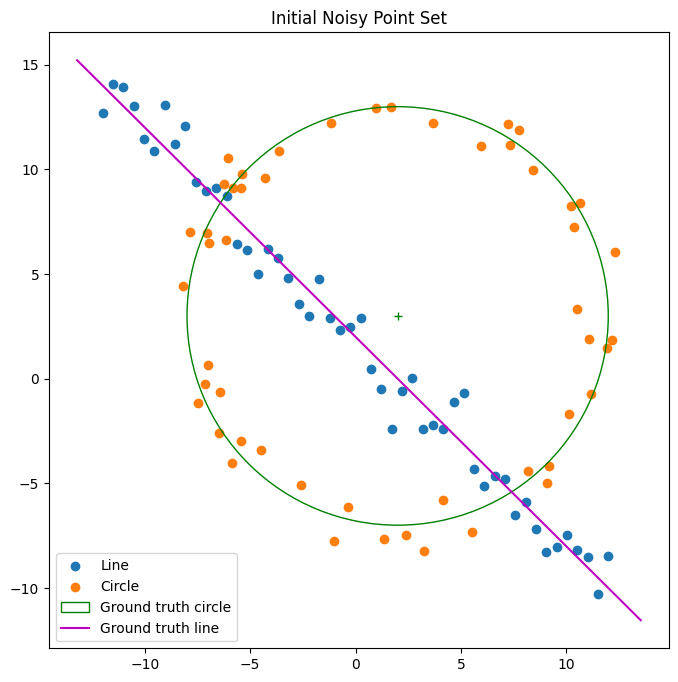

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.224084729829497e-11
            Iterations: 12
            Function evaluations: 59
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.79762798024475e-08
            Iterations: 9
            Function evaluations: 41
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.058127186021557e-09
            Iterations: 7
            Function evaluations: 34
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2439473080582177e-07
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3994697683309374e-09
            Iterations: 11
            Fu

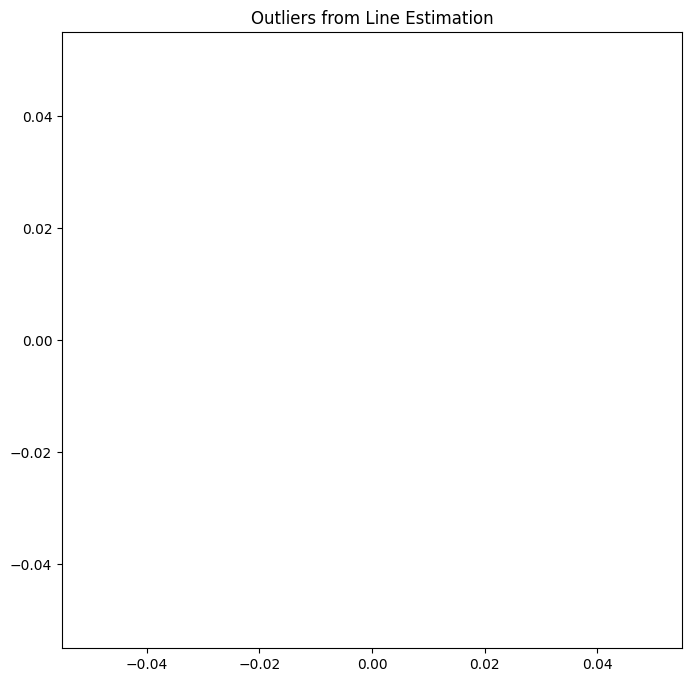

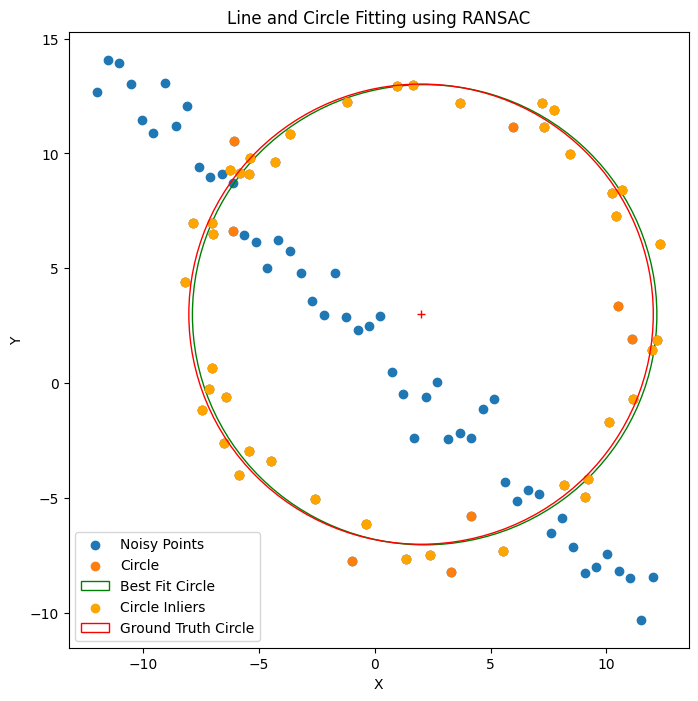

IndexError: list index out of range

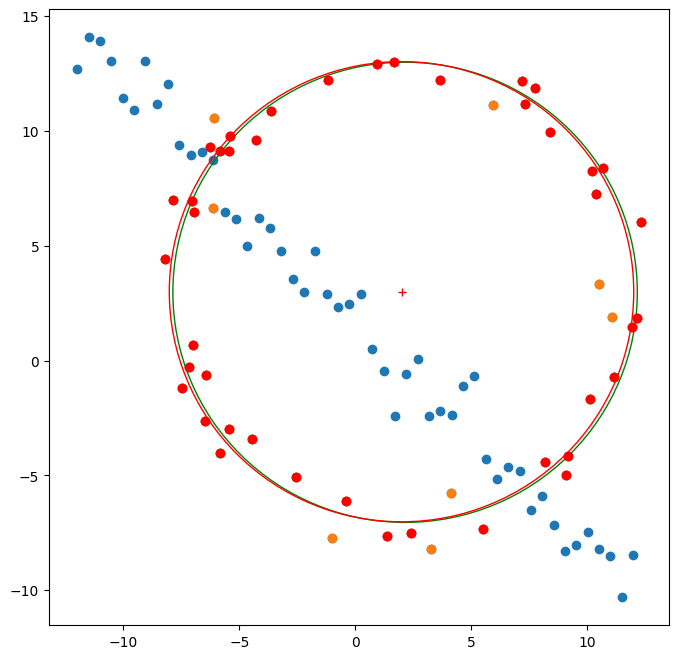

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import math
from scipy import optimize
import random
from matplotlib.patches import Circle

# Part 2: Generate Noisy Point Set

num_points = 100
half_num_points = num_points // 2
circle_radius = 10
circle_center_x, circle_center_y = 2, 3  # Center
noise_scale = circle_radius / 16

circle_angle = np.random.uniform(0, 2 * np.pi, half_num_points)
noise = noise_scale * np.random.randn(half_num_points)
x_coordinates = circle_center_x + (circle_radius + noise) * np.cos(circle_angle)
y_coordinates = circle_center_y + (circle_radius + noise) * np.sin(circle_angle)
circle_points = np.hstack((x_coordinates.reshape(half_num_points, 1), y_coordinates.reshape(half_num_points, 1)))

line_noise_scale = 1.0
line_slope, line_intercept = -1, 2
x_coordinates = np.linspace(-12, 12, half_num_points)
y_coordinates = line_slope * x_coordinates + line_intercept + line_noise_scale * np.random.randn(half_num_points)
line_points = np.hstack((x_coordinates.reshape(half_num_points, 1), y_coordinates.reshape(half_num_points, 1)))

noisy_points = np.vstack((circle_points, line_points))

# Plot the initial noisy point set
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(line_points[:, 0], line_points[:, 1], label='Line')
ax.scatter(circle_points[:, 0], circle_points[:, 1], label='Circle')

ground_truth_circle = plt.Circle((circle_center_x, circle_center_y), circle_radius, color='g', fill=False, label='Ground truth circle')
ax.add_patch(ground_truth_circle)
ax.plot(circle_center_x, circle_center_y, '+', color='g')

x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = line_slope * x_range + line_intercept
plt.plot(x_range, y_range, color='m', label='Ground truth line')

plt.legend()
plt.title('Initial Noisy Point Set')
plt.show()

# Part 3: Estimate the Line using RANSAC

def calculate_distance(x1, y1, x2, y2):
    distance_magnitude = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    a_coefficient = (x2 - x1) / distance_magnitude
    b_coefficient = (y2 - y1) / distance_magnitude
    d_value = a_coefficient * x1 + b_coefficient * y1
    return a_coefficient, b_coefficient, d_value

def total_least_squares(x, indices):
    a_coefficient = x[0]
    b_coefficient = x[1]
    d_value = x[2]
    return np.sum(np.square(a_coefficient * noisy_points[indices, 0] + b_coefficient * noisy_points[indices, 1] - d_value))

def constraint_function(x):
    return x[0] ** 2 + x[1] ** 2 - 1

constraints = ({'type': 'eq', 'fun': constraint_function})

def best_fit_line_estimate(noisy_points, x, threshold):
    a_coefficient = x[0]
    b_coefficient = x[1]
    d_value = x[2]
    error = np.absolute(a_coefficient * noisy_points[:, 0] + b_coefficient * noisy_points[:, 1] - d_value)
    return error < threshold

threshold_value = 1.0
minimum_inliers = 0.5 * num_points
sample_size = 2

line_inliers = []
circle_inliers = []

max_iterations = 100
current_iteration = 0
best_line_model = []
best_error = np.inf
best_sample_line = []
best_inlier_line = []

while current_iteration < max_iterations:
    sample_indices = np.random.randint(0, num_points, sample_size)
    initial_guess = np.array([1, 1, 0])
    result = minimize(fun=total_least_squares, args=sample_indices, x0=initial_guess, tol=1e-6, constraints=constraints, options={'disp': True})
    line_inliers = best_fit_line_estimate(noisy_points, result.x, threshold_value)

    if line_inliers.sum() > minimum_inliers:
        initial_guess = result.x
        result = minimize(fun=total_least_squares, args=line_inliers, x0=initial_guess, tol=1e-6, constraints=constraints, options={'disp': True})
        if result.fun < best_error:
            best_error = result.fun
            best_line_model = result.x
            best_sample_line = noisy_points[sample_indices, :]
            best_inlier_line = line_inliers
            result_with_sample = initial_guess
            print("Best line model: ", best_line_model)
            print("Best error: ", best_error)
            print("Best sample: ", best_sample_line)
            print("Best inlier: ", best_inlier_line)
            print("Number of inliers: ", best_inlier_line.sum())
            print("Number of outliers: ", num_points - best_inlier_line.sum())
            print("Number of iterations: ", current_iteration)
            print("------------------------------------------------------")

    current_iteration += 1

print("The Best Line model obtained: ", best_line_model)

# Part 4: Fit Circle to Remnant

def calculate_circle_parameters(points):
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]
    denominator = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    center_x = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / denominator
    center_y = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / denominator
    radius = np.sqrt((x1 - center_x)**2 + (y1 - center_y)**2)
    return center_x, center_y, radius

def fit_circle_ransac(points, num_iterations, error_threshold, min_consensus):
    best_circle = None
    best_inliers = []

    for _ in range(num_iterations):
        sample_indices = np.random.choice(len(points), 3, replace=False)
        sample_points = points[sample_indices]
        circle_x, circle_y, circle_radius = calculate_circle_parameters(sample_points)
        radial_errors = np.abs(np.sqrt((points[:, 0] - circle_x)**2 + (points[:, 1] - circle_y)**2) - circle_radius)
        inliers = np.where(radial_errors < error_threshold)[0]
        if len(inliers) >= min_consensus and len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_circle = (circle_x, circle_y, circle_radius)

    return best_circle, best_inliers

num_iterations_circle = 1000
error_threshold_circle = 0.85
min_consensus_circle = 40

best_circle, circle_inliers = fit_circle_ransac(circle_points, num_iterations_circle, error_threshold_circle, min_consensus_circle)

# Part 5: Visualize Line Outliers

line_outliers_indices = np.where(np.logical_not(best_inlier_line))[0]
line_outliers_data = noisy_points[line_outliers_indices, :]

plt.subplots(figsize=(8, 8))
plt.scatter(line_outliers_data[:, 0], line_outliers_data[:, 1])
plt.title('Outliers from Line Estimation')
plt.show()

# Part 6: Visualize Line and Circle Fitting

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for the noisy point set
ax.scatter(noisy_points[:, 0], noisy_points[:, 1], label='Noisy Points')
ax.scatter(circle_points[:, 0], circle_points[:, 1], label='Circle')

if best_circle is not None:  # Check if the circle was successfully estimated
    circle_x, circle_y, circle_radius = best_circle
    circle = Circle((circle_x, circle_y), circle_radius, color='green', fill=False, label='Best Fit Circle')
    ax.add_patch(circle)
    ax.scatter(circle_points[circle_inliers, 0], circle_points[circle_inliers, 1], color='orange', label='Circle Inliers')
ground_truth_circle = Circle((circle_center_x, circle_center_y), circle_radius, color='red', fill=False, label='Ground Truth Circle')
ax.add_patch(ground_truth_circle)
ax.plot(circle_center_x, circle_center_y, '+', color='red')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Line and Circle Fitting using RANSAC')

plt.show()

# Part 7: Visualize Line, Circle, and Inliers

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(noisy_points[:, 0], noisy_points[:, 1], label='Noisy Points')
ax.scatter(circle_points[:, 0], circle_points[:, 1], label='Circle')

circle_x, circle_y, circle_radius = best_circle
circle = Circle((circle_x, circle_y), circle_radius, color='green', fill=False, label='Best Fit Circle')
ax.add_patch(circle)
ax.scatter(circle_points[circle_inliers, 0], circle_points[circle_inliers, 1], color='red', label='Circle Inliers')
ground_truth_circle = Circle((circle_center_x, circle_center_y), circle_radius, color='red', fill=False, label='Ground Truth Circle')
ax.add_patch(ground_truth_circle)
ax.plot(circle_center_x, circle_center_y, '+', color='red')

x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = (-best_line_model[1] * x_range + best_line_model[2]) / best_line_model[1]
plt.plot(x_range, y_range, label='RANSAC line')
x_range = np.array([x_min, x_max])
y_range = line_slope * x_range + line_intercept
plt.plot(x_range, y_range, color='m', label='Ground truth line')
plt.legend()
plt.show()
